## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-06-03 20:44:55--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.161.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.161.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M   102MB/s    in 3.4s    

2020-06-03 20:44:58 (95.4 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28224, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=136, bias=True)
  (drop1): Dropout(p=0.4)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose( [Rescale(100) , RandomCrop(96) , Normalize() , ToTensor()] )

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 96, 96]) torch.Size([68, 2])
1 torch.Size([1, 96, 96]) torch.Size([68, 2])
2 torch.Size([1, 96, 96]) torch.Size([68, 2])
3 torch.Size([1, 96, 96]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 96, 96])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

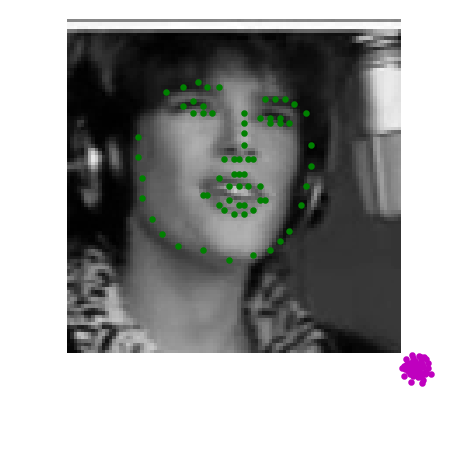

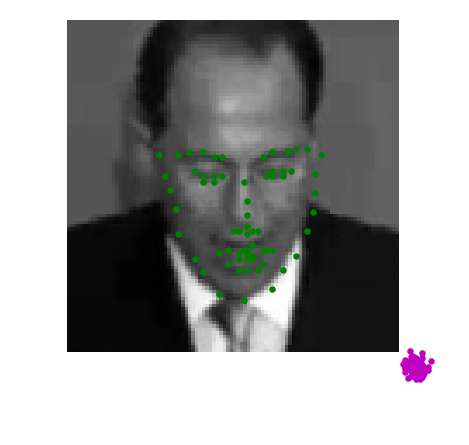

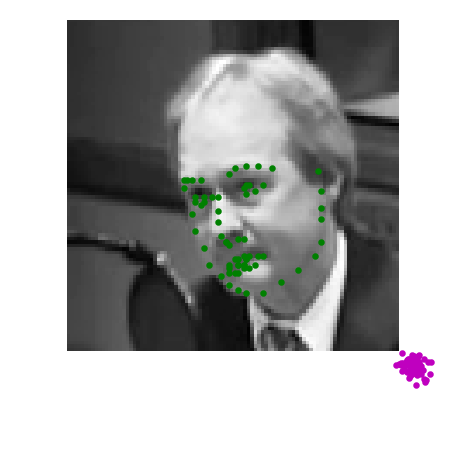

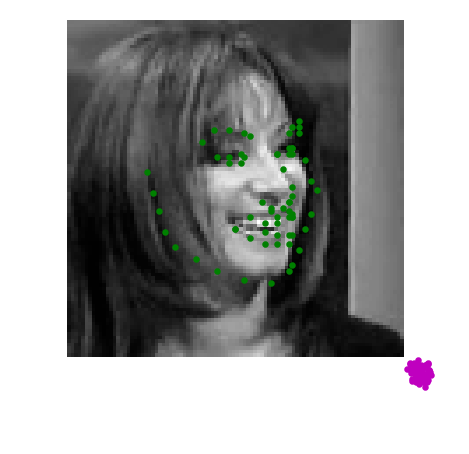

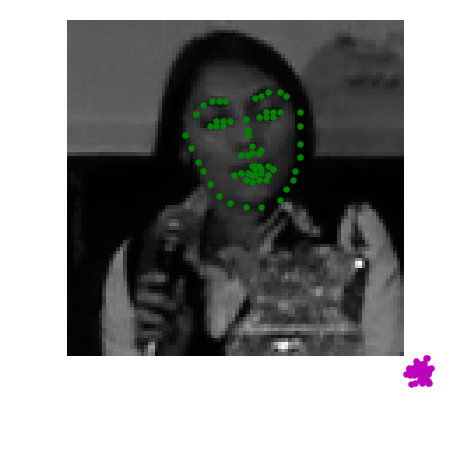

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [15]:
# train your network
n_epochs = 25 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.39991628378629684
Epoch: 1, Batch: 20, Avg. Loss: 0.14929121509194374
Epoch: 1, Batch: 30, Avg. Loss: 0.09572630971670151
Epoch: 1, Batch: 40, Avg. Loss: 0.061243672668933866
Epoch: 1, Batch: 50, Avg. Loss: 0.04201125875115395
Epoch: 1, Batch: 60, Avg. Loss: 0.039794419705867765
Epoch: 1, Batch: 70, Avg. Loss: 0.05263986997306347
Epoch: 1, Batch: 80, Avg. Loss: 0.02991883959621191
Epoch: 1, Batch: 90, Avg. Loss: 0.030635137856006623
Epoch: 1, Batch: 100, Avg. Loss: 0.030174496956169604
Epoch: 1, Batch: 110, Avg. Loss: 0.025876559130847455
Epoch: 1, Batch: 120, Avg. Loss: 0.03470673207193613
Epoch: 1, Batch: 130, Avg. Loss: 0.030863485112786294
Epoch: 1, Batch: 140, Avg. Loss: 0.026356386207044124
Epoch: 1, Batch: 150, Avg. Loss: 0.024368740618228912
Epoch: 1, Batch: 160, Avg. Loss: 0.028646240569651128
Epoch: 1, Batch: 170, Avg. Loss: 0.025495707988739014
Epoch: 1, Batch: 180, Avg. Loss: 0.025415262207388878
Epoch: 1, Batch: 190, Avg. Loss: 0.029246974

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.02026490345597267
Epoch: 2, Batch: 20, Avg. Loss: 0.01787191554903984
Epoch: 2, Batch: 30, Avg. Loss: 0.023358346521854402
Epoch: 2, Batch: 40, Avg. Loss: 0.01997018661350012
Epoch: 2, Batch: 50, Avg. Loss: 0.022318254970014096
Epoch: 2, Batch: 60, Avg. Loss: 0.017884252313524484
Epoch: 2, Batch: 70, Avg. Loss: 0.0150501461699605
Epoch: 2, Batch: 80, Avg. Loss: 0.018814569991081952
Epoch: 2, Batch: 90, Avg. Loss: 0.017537173256278037
Epoch: 2, Batch: 100, Avg. Loss: 0.022630580142140387
Epoch: 2, Batch: 110, Avg. Loss: 0.025487217772752046
Epoch: 2, Batch: 120, Avg. Loss: 0.02181961489841342
Epoch: 2, Batch: 130, Avg. Loss: 0.014832871966063976
Epoch: 2, Batch: 140, Avg. Loss: 0.021206552814692258
Epoch: 2, Batch: 150, Avg. Loss: 0.018840621039271355
Epoch: 2, Batch: 160, Avg. Loss: 0.016399835981428624
Epoch: 2, Batch: 170, Avg. Loss: 0.01677828226238489
Epoch: 2, Batch: 180, Avg. Loss: 0.01602872125804424
Epoch: 2, Batch: 190, Avg. Loss: 0.0167772834

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.019751478172838687
Epoch: 3, Batch: 20, Avg. Loss: 0.019415192306041718
Epoch: 3, Batch: 30, Avg. Loss: 0.01572435609996319
Epoch: 3, Batch: 40, Avg. Loss: 0.015088093560189008
Epoch: 3, Batch: 50, Avg. Loss: 0.013337225280702114
Epoch: 3, Batch: 60, Avg. Loss: 0.012883457820862532
Epoch: 3, Batch: 70, Avg. Loss: 0.012166671780869364
Epoch: 3, Batch: 80, Avg. Loss: 0.01809811722487211
Epoch: 3, Batch: 90, Avg. Loss: 0.013745197001844645
Epoch: 3, Batch: 100, Avg. Loss: 0.013120602816343307
Epoch: 3, Batch: 110, Avg. Loss: 0.012795885279774665
Epoch: 3, Batch: 120, Avg. Loss: 0.013815922476351262
Epoch: 3, Batch: 130, Avg. Loss: 0.014086110517382622
Epoch: 3, Batch: 140, Avg. Loss: 0.017721264343708753
Epoch: 3, Batch: 150, Avg. Loss: 0.012797751324251294
Epoch: 3, Batch: 160, Avg. Loss: 0.013095440063625573
Epoch: 3, Batch: 170, Avg. Loss: 0.011936652986332775
Epoch: 3, Batch: 180, Avg. Loss: 0.01486610909923911
Epoch: 3, Batch: 190, Avg. Loss: 0.01170

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.014123074896633624
Epoch: 4, Batch: 20, Avg. Loss: 0.011763784661889076
Epoch: 4, Batch: 30, Avg. Loss: 0.011153075005859136
Epoch: 4, Batch: 40, Avg. Loss: 0.011338225146755577
Epoch: 4, Batch: 50, Avg. Loss: 0.012386682303622365
Epoch: 4, Batch: 60, Avg. Loss: 0.0113447405397892
Epoch: 4, Batch: 70, Avg. Loss: 0.010286614391952753
Epoch: 4, Batch: 80, Avg. Loss: 0.012068774225190282
Epoch: 4, Batch: 90, Avg. Loss: 0.010256112180650234
Epoch: 4, Batch: 100, Avg. Loss: 0.010049495846033096
Epoch: 4, Batch: 110, Avg. Loss: 0.011314046615734697
Epoch: 4, Batch: 120, Avg. Loss: 0.009354573953896762
Epoch: 4, Batch: 130, Avg. Loss: 0.011981689301319421
Epoch: 4, Batch: 140, Avg. Loss: 0.007462619058787823
Epoch: 4, Batch: 150, Avg. Loss: 0.010191727476194502
Epoch: 4, Batch: 160, Avg. Loss: 0.011370500037446617
Epoch: 4, Batch: 170, Avg. Loss: 0.014814909361302853
Epoch: 4, Batch: 180, Avg. Loss: 0.010013600601814688
Epoch: 4, Batch: 190, Avg. Loss: 0.0120

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.010164010850712658
Epoch: 5, Batch: 20, Avg. Loss: 0.010765695804730057
Epoch: 5, Batch: 30, Avg. Loss: 0.007913894625380636
Epoch: 5, Batch: 40, Avg. Loss: 0.01093672919087112
Epoch: 5, Batch: 50, Avg. Loss: 0.008963294327259064
Epoch: 5, Batch: 60, Avg. Loss: 0.010588769614696503
Epoch: 5, Batch: 70, Avg. Loss: 0.009575946000404656
Epoch: 5, Batch: 80, Avg. Loss: 0.009572105575352907
Epoch: 5, Batch: 90, Avg. Loss: 0.010546390851959585
Epoch: 5, Batch: 100, Avg. Loss: 0.010386519134044647
Epoch: 5, Batch: 110, Avg. Loss: 0.008825788274407387
Epoch: 5, Batch: 120, Avg. Loss: 0.009559944039210677
Epoch: 5, Batch: 130, Avg. Loss: 0.009518807800486685
Epoch: 5, Batch: 140, Avg. Loss: 0.010238981246948243
Epoch: 5, Batch: 150, Avg. Loss: 0.007951044500805438
Epoch: 5, Batch: 160, Avg. Loss: 0.009373909700661898
Epoch: 5, Batch: 170, Avg. Loss: 0.009633751981891692
Epoch: 5, Batch: 180, Avg. Loss: 0.00999853010289371
Epoch: 5, Batch: 190, Avg. Loss: 0.0114

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.007176424143835902
Epoch: 6, Batch: 20, Avg. Loss: 0.00910205147229135
Epoch: 6, Batch: 30, Avg. Loss: 0.007204807782545686
Epoch: 6, Batch: 40, Avg. Loss: 0.008586033270694316
Epoch: 6, Batch: 50, Avg. Loss: 0.006808413378894329
Epoch: 6, Batch: 60, Avg. Loss: 0.006726097920909524
Epoch: 6, Batch: 70, Avg. Loss: 0.010227039456367493
Epoch: 6, Batch: 80, Avg. Loss: 0.008323027472943067
Epoch: 6, Batch: 90, Avg. Loss: 0.009967594360932707
Epoch: 6, Batch: 100, Avg. Loss: 0.006985622644424439
Epoch: 6, Batch: 110, Avg. Loss: 0.009485520888119936
Epoch: 6, Batch: 120, Avg. Loss: 0.009593021916225552
Epoch: 6, Batch: 130, Avg. Loss: 0.009279146837070585
Epoch: 6, Batch: 140, Avg. Loss: 0.0077479747124016285
Epoch: 6, Batch: 150, Avg. Loss: 0.007593279937282205
Epoch: 6, Batch: 160, Avg. Loss: 0.009331712545827032
Epoch: 6, Batch: 170, Avg. Loss: 0.006698161968961358
Epoch: 6, Batch: 180, Avg. Loss: 0.007560267997905612
Epoch: 6, Batch: 190, Avg. Loss: 0.00

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.010549240838736295
Epoch: 7, Batch: 20, Avg. Loss: 0.010454408917576074
Epoch: 7, Batch: 30, Avg. Loss: 0.006622493825852871
Epoch: 7, Batch: 40, Avg. Loss: 0.006222766544669867
Epoch: 7, Batch: 50, Avg. Loss: 0.006234480766579509
Epoch: 7, Batch: 60, Avg. Loss: 0.009509871061891318
Epoch: 7, Batch: 70, Avg. Loss: 0.006854857597500086
Epoch: 7, Batch: 80, Avg. Loss: 0.0055964377243071795
Epoch: 7, Batch: 90, Avg. Loss: 0.010017662774771452
Epoch: 7, Batch: 100, Avg. Loss: 0.006309868441894651
Epoch: 7, Batch: 110, Avg. Loss: 0.007851173356175422
Epoch: 7, Batch: 120, Avg. Loss: 0.010328981769271195
Epoch: 7, Batch: 130, Avg. Loss: 0.007773348549380899
Epoch: 7, Batch: 140, Avg. Loss: 0.00884347055107355
Epoch: 7, Batch: 150, Avg. Loss: 0.013500652299262584
Epoch: 7, Batch: 160, Avg. Loss: 0.007370436261408031
Epoch: 7, Batch: 170, Avg. Loss: 0.007738182810135186
Epoch: 7, Batch: 180, Avg. Loss: 0.012772061489522457
Epoch: 7, Batch: 190, Avg. Loss: 0.00

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.008770326804369687
Epoch: 8, Batch: 20, Avg. Loss: 0.005888183647766709
Epoch: 8, Batch: 30, Avg. Loss: 0.006413530092686415
Epoch: 8, Batch: 40, Avg. Loss: 0.010406084824353456
Epoch: 8, Batch: 50, Avg. Loss: 0.008818421280011535
Epoch: 8, Batch: 60, Avg. Loss: 0.00829881657846272
Epoch: 8, Batch: 70, Avg. Loss: 0.006231679860502481
Epoch: 8, Batch: 80, Avg. Loss: 0.006730340886861086
Epoch: 8, Batch: 90, Avg. Loss: 0.007262251526117325
Epoch: 8, Batch: 100, Avg. Loss: 0.008836821187287569
Epoch: 8, Batch: 110, Avg. Loss: 0.006973871355876326
Epoch: 8, Batch: 120, Avg. Loss: 0.0073534372262656685
Epoch: 8, Batch: 130, Avg. Loss: 0.006730668665841222
Epoch: 8, Batch: 140, Avg. Loss: 0.007755878614261746
Epoch: 8, Batch: 150, Avg. Loss: 0.00939375429879874
Epoch: 8, Batch: 160, Avg. Loss: 0.00754608828574419
Epoch: 8, Batch: 170, Avg. Loss: 0.01065906984731555
Epoch: 8, Batch: 180, Avg. Loss: 0.0071106018964201215
Epoch: 8, Batch: 190, Avg. Loss: 0.0074

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.007510211877524852
Epoch: 9, Batch: 20, Avg. Loss: 0.0063845851924270395
Epoch: 9, Batch: 30, Avg. Loss: 0.006485194549895823
Epoch: 9, Batch: 40, Avg. Loss: 0.0068530537188053135
Epoch: 9, Batch: 50, Avg. Loss: 0.005853196140378714
Epoch: 9, Batch: 60, Avg. Loss: 0.005717361625283956
Epoch: 9, Batch: 70, Avg. Loss: 0.00484915217384696
Epoch: 9, Batch: 80, Avg. Loss: 0.007162836124189198
Epoch: 9, Batch: 90, Avg. Loss: 0.007759385020472109
Epoch: 9, Batch: 100, Avg. Loss: 0.006759893381968141
Epoch: 9, Batch: 110, Avg. Loss: 0.006939661549404263
Epoch: 9, Batch: 120, Avg. Loss: 0.005997510254383087
Epoch: 9, Batch: 130, Avg. Loss: 0.006457944866269827
Epoch: 9, Batch: 140, Avg. Loss: 0.006443873094394803
Epoch: 9, Batch: 150, Avg. Loss: 0.005979060661047697
Epoch: 9, Batch: 160, Avg. Loss: 0.006426736293360591
Epoch: 9, Batch: 170, Avg. Loss: 0.0064349059714004396
Epoch: 9, Batch: 180, Avg. Loss: 0.0078346133697778
Epoch: 9, Batch: 190, Avg. Loss: 0.01

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.006112269451841712
Epoch: 10, Batch: 20, Avg. Loss: 0.0061533700209110975
Epoch: 10, Batch: 30, Avg. Loss: 0.005290954140946269
Epoch: 10, Batch: 40, Avg. Loss: 0.007948832307010888
Epoch: 10, Batch: 50, Avg. Loss: 0.006430494505912066
Epoch: 10, Batch: 60, Avg. Loss: 0.006065477943047881
Epoch: 10, Batch: 70, Avg. Loss: 0.005933741899207234
Epoch: 10, Batch: 80, Avg. Loss: 0.01088470199611038
Epoch: 10, Batch: 90, Avg. Loss: 0.00555215363856405
Epoch: 10, Batch: 100, Avg. Loss: 0.0068592599127441645
Epoch: 10, Batch: 110, Avg. Loss: 0.006512076640501618
Epoch: 10, Batch: 120, Avg. Loss: 0.005669269012287259
Epoch: 10, Batch: 130, Avg. Loss: 0.005406092875637114
Epoch: 10, Batch: 140, Avg. Loss: 0.008463702420704067
Epoch: 10, Batch: 150, Avg. Loss: 0.007115438347682357
Epoch: 10, Batch: 160, Avg. Loss: 0.007441131351515651
Epoch: 10, Batch: 170, Avg. Loss: 0.01402887273579836
Epoch: 10, Batch: 180, Avg. Loss: 0.006165676773525775
Epoch: 10, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.005636025918647647
Epoch: 11, Batch: 20, Avg. Loss: 0.0054381322581321
Epoch: 11, Batch: 30, Avg. Loss: 0.005354708503000438
Epoch: 11, Batch: 40, Avg. Loss: 0.0046781542710959915
Epoch: 11, Batch: 50, Avg. Loss: 0.00798564227297902
Epoch: 11, Batch: 60, Avg. Loss: 0.005883267684839666
Epoch: 11, Batch: 70, Avg. Loss: 0.006045481259934604
Epoch: 11, Batch: 80, Avg. Loss: 0.004534723632968962
Epoch: 11, Batch: 90, Avg. Loss: 0.004311982914805413
Epoch: 11, Batch: 100, Avg. Loss: 0.010894582560285925
Epoch: 11, Batch: 110, Avg. Loss: 0.005420663650147617
Epoch: 11, Batch: 120, Avg. Loss: 0.006054363143630326
Epoch: 11, Batch: 130, Avg. Loss: 0.00640000756829977
Epoch: 11, Batch: 140, Avg. Loss: 0.006407527392730117
Epoch: 11, Batch: 150, Avg. Loss: 0.006190414633601904
Epoch: 11, Batch: 160, Avg. Loss: 0.009103328920900822
Epoch: 11, Batch: 170, Avg. Loss: 0.006121612619608641
Epoch: 11, Batch: 180, Avg. Loss: 0.005061708833090961
Epoch: 11, Batch: 190,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.005433799303136766
Epoch: 12, Batch: 20, Avg. Loss: 0.006068813940510153
Epoch: 12, Batch: 30, Avg. Loss: 0.005526700429618359
Epoch: 12, Batch: 40, Avg. Loss: 0.005382862105034292
Epoch: 12, Batch: 50, Avg. Loss: 0.004895503143779933
Epoch: 12, Batch: 60, Avg. Loss: 0.006406166544184089
Epoch: 12, Batch: 70, Avg. Loss: 0.004447872820310295
Epoch: 12, Batch: 80, Avg. Loss: 0.00495467868167907
Epoch: 12, Batch: 90, Avg. Loss: 0.008530613593757152
Epoch: 12, Batch: 100, Avg. Loss: 0.00537293991073966
Epoch: 12, Batch: 110, Avg. Loss: 0.007305789715610444
Epoch: 12, Batch: 120, Avg. Loss: 0.005992553802207113
Epoch: 12, Batch: 130, Avg. Loss: 0.0076612563803792
Epoch: 12, Batch: 140, Avg. Loss: 0.00491418621968478
Epoch: 12, Batch: 150, Avg. Loss: 0.006005694204941392
Epoch: 12, Batch: 160, Avg. Loss: 0.005743853352032602
Epoch: 12, Batch: 170, Avg. Loss: 0.005797358474228531
Epoch: 12, Batch: 180, Avg. Loss: 0.005336867668665946
Epoch: 12, Batch: 190, A

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.00656528864055872
Epoch: 13, Batch: 20, Avg. Loss: 0.006049542012624443
Epoch: 13, Batch: 30, Avg. Loss: 0.00691793120931834
Epoch: 13, Batch: 40, Avg. Loss: 0.007173419022001326
Epoch: 13, Batch: 50, Avg. Loss: 0.0060589626431465145
Epoch: 13, Batch: 60, Avg. Loss: 0.006825357396155596
Epoch: 13, Batch: 70, Avg. Loss: 0.004616375872865319
Epoch: 13, Batch: 80, Avg. Loss: 0.005483194184489548
Epoch: 13, Batch: 90, Avg. Loss: 0.003904779232107103
Epoch: 13, Batch: 100, Avg. Loss: 0.004624823853373527
Epoch: 13, Batch: 110, Avg. Loss: 0.0071615750901401045
Epoch: 13, Batch: 120, Avg. Loss: 0.006769054452888668
Epoch: 13, Batch: 130, Avg. Loss: 0.00656801019795239
Epoch: 13, Batch: 140, Avg. Loss: 0.0050297982292249795
Epoch: 13, Batch: 150, Avg. Loss: 0.005054387729614973
Epoch: 13, Batch: 160, Avg. Loss: 0.004645824735052884
Epoch: 13, Batch: 170, Avg. Loss: 0.005731272068805993
Epoch: 13, Batch: 180, Avg. Loss: 0.005411567469127476
Epoch: 13, Batch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.004347423929721117
Epoch: 14, Batch: 20, Avg. Loss: 0.00692571431864053
Epoch: 14, Batch: 30, Avg. Loss: 0.005938696535304188
Epoch: 14, Batch: 40, Avg. Loss: 0.005808444158174097
Epoch: 14, Batch: 50, Avg. Loss: 0.005978630296885968
Epoch: 14, Batch: 60, Avg. Loss: 0.005500066559761763
Epoch: 14, Batch: 70, Avg. Loss: 0.009475342812947929
Epoch: 14, Batch: 80, Avg. Loss: 0.007621444948017597
Epoch: 14, Batch: 90, Avg. Loss: 0.00766341311391443
Epoch: 14, Batch: 100, Avg. Loss: 0.005782745638862252
Epoch: 14, Batch: 110, Avg. Loss: 0.005645416537299752
Epoch: 14, Batch: 120, Avg. Loss: 0.010526931739877909
Epoch: 14, Batch: 130, Avg. Loss: 0.0057421283097937705
Epoch: 14, Batch: 140, Avg. Loss: 0.004705362115055322
Epoch: 14, Batch: 150, Avg. Loss: 0.005164688872173429
Epoch: 14, Batch: 160, Avg. Loss: 0.00521047783549875
Epoch: 14, Batch: 170, Avg. Loss: 0.004690920864231884
Epoch: 14, Batch: 180, Avg. Loss: 0.006077099335379898
Epoch: 14, Batch: 190

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.005103509384207427
Epoch: 15, Batch: 20, Avg. Loss: 0.005743537936359644
Epoch: 15, Batch: 30, Avg. Loss: 0.006452119769528508
Epoch: 15, Batch: 40, Avg. Loss: 0.005389232514426112
Epoch: 15, Batch: 50, Avg. Loss: 0.006120787537656725
Epoch: 15, Batch: 60, Avg. Loss: 0.00578811732120812
Epoch: 15, Batch: 70, Avg. Loss: 0.005894883535802364
Epoch: 15, Batch: 80, Avg. Loss: 0.004042199626564979
Epoch: 15, Batch: 90, Avg. Loss: 0.003832075954414904
Epoch: 15, Batch: 100, Avg. Loss: 0.004444265551865101
Epoch: 15, Batch: 110, Avg. Loss: 0.003957396885380149
Epoch: 15, Batch: 120, Avg. Loss: 0.0054114290280267595
Epoch: 15, Batch: 130, Avg. Loss: 0.00455451977904886
Epoch: 15, Batch: 140, Avg. Loss: 0.013963779411278665
Epoch: 15, Batch: 150, Avg. Loss: 0.00569108659401536
Epoch: 15, Batch: 160, Avg. Loss: 0.004541797423735261
Epoch: 15, Batch: 170, Avg. Loss: 0.005094690108671784
Epoch: 15, Batch: 180, Avg. Loss: 0.0047369359759613875
Epoch: 15, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.005085668619722128
Epoch: 16, Batch: 20, Avg. Loss: 0.005132170347496867
Epoch: 16, Batch: 30, Avg. Loss: 0.004226109990850091
Epoch: 16, Batch: 40, Avg. Loss: 0.005048295389860869
Epoch: 16, Batch: 50, Avg. Loss: 0.0046696555335074665
Epoch: 16, Batch: 60, Avg. Loss: 0.004358486551791429
Epoch: 16, Batch: 70, Avg. Loss: 0.00373601948376745
Epoch: 16, Batch: 80, Avg. Loss: 0.004157757153734565
Epoch: 16, Batch: 90, Avg. Loss: 0.00846277317032218
Epoch: 16, Batch: 100, Avg. Loss: 0.0059588513802737
Epoch: 16, Batch: 110, Avg. Loss: 0.004817148461006582
Epoch: 16, Batch: 120, Avg. Loss: 0.00627692281268537
Epoch: 16, Batch: 130, Avg. Loss: 0.006399739300832152
Epoch: 16, Batch: 140, Avg. Loss: 0.005536661599762738
Epoch: 16, Batch: 150, Avg. Loss: 0.004838951933197677
Epoch: 16, Batch: 160, Avg. Loss: 0.007230091281235218
Epoch: 16, Batch: 170, Avg. Loss: 0.004851148603484035
Epoch: 16, Batch: 180, Avg. Loss: 0.005354154598899185
Epoch: 16, Batch: 190, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.005532284779474139
Epoch: 17, Batch: 20, Avg. Loss: 0.005113995098508894
Epoch: 17, Batch: 30, Avg. Loss: 0.006016571423970163
Epoch: 17, Batch: 40, Avg. Loss: 0.004781310982070863
Epoch: 17, Batch: 50, Avg. Loss: 0.00477345185354352
Epoch: 17, Batch: 60, Avg. Loss: 0.004701097076758742
Epoch: 17, Batch: 70, Avg. Loss: 0.005654105613939464
Epoch: 17, Batch: 80, Avg. Loss: 0.004848141619004309
Epoch: 17, Batch: 90, Avg. Loss: 0.004775433614850044
Epoch: 17, Batch: 100, Avg. Loss: 0.0045328472508117555
Epoch: 17, Batch: 110, Avg. Loss: 0.005003824410960078
Epoch: 17, Batch: 120, Avg. Loss: 0.00487437336705625
Epoch: 17, Batch: 130, Avg. Loss: 0.004488756274804473
Epoch: 17, Batch: 140, Avg. Loss: 0.004260781477205456
Epoch: 17, Batch: 150, Avg. Loss: 0.004216287168674171
Epoch: 17, Batch: 160, Avg. Loss: 0.008077272027730942
Epoch: 17, Batch: 170, Avg. Loss: 0.004417169862426818
Epoch: 17, Batch: 180, Avg. Loss: 0.005404877383261919
Epoch: 17, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.004578677052631974
Epoch: 18, Batch: 20, Avg. Loss: 0.004670608253218233
Epoch: 18, Batch: 30, Avg. Loss: 0.005572505504824221
Epoch: 18, Batch: 40, Avg. Loss: 0.0058876883937045935
Epoch: 18, Batch: 50, Avg. Loss: 0.0047130191698670386
Epoch: 18, Batch: 60, Avg. Loss: 0.01441184114664793
Epoch: 18, Batch: 70, Avg. Loss: 0.006261415919288993
Epoch: 18, Batch: 80, Avg. Loss: 0.004455826967023313
Epoch: 18, Batch: 90, Avg. Loss: 0.005002337810583413
Epoch: 18, Batch: 100, Avg. Loss: 0.005237062834203244
Epoch: 18, Batch: 110, Avg. Loss: 0.006319997739046812
Epoch: 18, Batch: 120, Avg. Loss: 0.003819123492576182
Epoch: 18, Batch: 130, Avg. Loss: 0.004548141709528863
Epoch: 18, Batch: 140, Avg. Loss: 0.004040952562354505
Epoch: 18, Batch: 150, Avg. Loss: 0.004901543562300503
Epoch: 18, Batch: 160, Avg. Loss: 0.004664522898383439
Epoch: 18, Batch: 170, Avg. Loss: 0.004897412797436118
Epoch: 18, Batch: 180, Avg. Loss: 0.0044721799204126
Epoch: 18, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.0034866622416302563
Epoch: 19, Batch: 20, Avg. Loss: 0.004777990956790745
Epoch: 19, Batch: 30, Avg. Loss: 0.011337760649621487
Epoch: 19, Batch: 40, Avg. Loss: 0.005641032964922488
Epoch: 19, Batch: 50, Avg. Loss: 0.0035550891887396576
Epoch: 19, Batch: 60, Avg. Loss: 0.004467036831192673
Epoch: 19, Batch: 70, Avg. Loss: 0.004149435739964247
Epoch: 19, Batch: 80, Avg. Loss: 0.005209501506760717
Epoch: 19, Batch: 90, Avg. Loss: 0.0054835883202031255
Epoch: 19, Batch: 100, Avg. Loss: 0.0042307353112846615
Epoch: 19, Batch: 110, Avg. Loss: 0.007070443965494633
Epoch: 19, Batch: 120, Avg. Loss: 0.004551576683297753
Epoch: 19, Batch: 130, Avg. Loss: 0.007870424608699977
Epoch: 19, Batch: 140, Avg. Loss: 0.0070763595402240755
Epoch: 19, Batch: 150, Avg. Loss: 0.00479810715187341
Epoch: 19, Batch: 160, Avg. Loss: 0.0052798693533986805
Epoch: 19, Batch: 170, Avg. Loss: 0.005728719034232199
Epoch: 19, Batch: 180, Avg. Loss: 0.004058106103911996
Epoch: 19, Bat

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.005580817558802664
Epoch: 20, Batch: 20, Avg. Loss: 0.00407153582200408
Epoch: 20, Batch: 30, Avg. Loss: 0.0051475128857418895
Epoch: 20, Batch: 40, Avg. Loss: 0.0048288207734003665
Epoch: 20, Batch: 50, Avg. Loss: 0.004924655286595225
Epoch: 20, Batch: 60, Avg. Loss: 0.004446305031888187
Epoch: 20, Batch: 70, Avg. Loss: 0.01551069775596261
Epoch: 20, Batch: 80, Avg. Loss: 0.006784795434214175
Epoch: 20, Batch: 90, Avg. Loss: 0.004977913154289126
Epoch: 20, Batch: 100, Avg. Loss: 0.005527889006771147
Epoch: 20, Batch: 110, Avg. Loss: 0.006541758636012673
Epoch: 20, Batch: 120, Avg. Loss: 0.004617478512227535
Epoch: 20, Batch: 130, Avg. Loss: 0.007401782972738147
Epoch: 20, Batch: 140, Avg. Loss: 0.006675881543196737
Epoch: 20, Batch: 150, Avg. Loss: 0.005547892581671476
Epoch: 20, Batch: 160, Avg. Loss: 0.0049773053731769325
Epoch: 20, Batch: 170, Avg. Loss: 0.004395529069006443
Epoch: 20, Batch: 180, Avg. Loss: 0.004872433282434941
Epoch: 20, Batch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.00431831986643374
Epoch: 21, Batch: 20, Avg. Loss: 0.004030677070841193
Epoch: 21, Batch: 30, Avg. Loss: 0.0049443477764725685
Epoch: 21, Batch: 40, Avg. Loss: 0.0044916067505255345
Epoch: 21, Batch: 50, Avg. Loss: 0.007746053696610034
Epoch: 21, Batch: 60, Avg. Loss: 0.004567023948766291
Epoch: 21, Batch: 70, Avg. Loss: 0.005297737289220094
Epoch: 21, Batch: 80, Avg. Loss: 0.004226164845749736
Epoch: 21, Batch: 90, Avg. Loss: 0.004360090405680239
Epoch: 21, Batch: 100, Avg. Loss: 0.005764342832844704
Epoch: 21, Batch: 110, Avg. Loss: 0.004612043150700629
Epoch: 21, Batch: 120, Avg. Loss: 0.005228838487528265
Epoch: 21, Batch: 130, Avg. Loss: 0.004466006765142083
Epoch: 21, Batch: 140, Avg. Loss: 0.0035083407070487737
Epoch: 21, Batch: 150, Avg. Loss: 0.003860246017575264
Epoch: 21, Batch: 160, Avg. Loss: 0.004377776733599603
Epoch: 21, Batch: 170, Avg. Loss: 0.004938420676626265
Epoch: 21, Batch: 180, Avg. Loss: 0.003632959327660501
Epoch: 21, Batch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.003823123476468027
Epoch: 22, Batch: 20, Avg. Loss: 0.003970714728347957
Epoch: 22, Batch: 30, Avg. Loss: 0.00552560503128916
Epoch: 22, Batch: 40, Avg. Loss: 0.003596239141188562
Epoch: 22, Batch: 50, Avg. Loss: 0.005134747712872922
Epoch: 22, Batch: 60, Avg. Loss: 0.004306993517093361
Epoch: 22, Batch: 70, Avg. Loss: 0.005120368907228112
Epoch: 22, Batch: 80, Avg. Loss: 0.0038651491282507776
Epoch: 22, Batch: 90, Avg. Loss: 0.0056320119882002475
Epoch: 22, Batch: 100, Avg. Loss: 0.0041499667102471
Epoch: 22, Batch: 110, Avg. Loss: 0.005866116797551513
Epoch: 22, Batch: 120, Avg. Loss: 0.006363910529762507
Epoch: 22, Batch: 130, Avg. Loss: 0.005217854748480022
Epoch: 22, Batch: 140, Avg. Loss: 0.004406453517731279
Epoch: 22, Batch: 150, Avg. Loss: 0.005101239029318094
Epoch: 22, Batch: 160, Avg. Loss: 0.0036983778467401863
Epoch: 22, Batch: 170, Avg. Loss: 0.006513901287689805
Epoch: 22, Batch: 180, Avg. Loss: 0.005728593538515269
Epoch: 22, Batch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.005595674715004861
Epoch: 23, Batch: 20, Avg. Loss: 0.008422883972525597
Epoch: 23, Batch: 30, Avg. Loss: 0.010290657775476575
Epoch: 23, Batch: 40, Avg. Loss: 0.007635905174538493
Epoch: 23, Batch: 50, Avg. Loss: 0.006049827509559691
Epoch: 23, Batch: 60, Avg. Loss: 0.004650811152532697
Epoch: 23, Batch: 70, Avg. Loss: 0.004168534162454307
Epoch: 23, Batch: 80, Avg. Loss: 0.004420958971604705
Epoch: 23, Batch: 90, Avg. Loss: 0.008202800899744034
Epoch: 23, Batch: 100, Avg. Loss: 0.0056060693925246595
Epoch: 23, Batch: 110, Avg. Loss: 0.005259860656224191
Epoch: 23, Batch: 120, Avg. Loss: 0.006441864068619907
Epoch: 23, Batch: 130, Avg. Loss: 0.0038651237729936836
Epoch: 23, Batch: 140, Avg. Loss: 0.0048831429099664096
Epoch: 23, Batch: 150, Avg. Loss: 0.00405798964202404
Epoch: 23, Batch: 160, Avg. Loss: 0.0041233842261135575
Epoch: 23, Batch: 170, Avg. Loss: 0.004197000642307103
Epoch: 23, Batch: 180, Avg. Loss: 0.009406659414526074
Epoch: 23, Batch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.004416232462972403
Epoch: 24, Batch: 20, Avg. Loss: 0.004709306708537042
Epoch: 24, Batch: 30, Avg. Loss: 0.005749665782786906
Epoch: 24, Batch: 40, Avg. Loss: 0.0038375718984752895
Epoch: 24, Batch: 50, Avg. Loss: 0.004941562633030116
Epoch: 24, Batch: 60, Avg. Loss: 0.00754206107230857
Epoch: 24, Batch: 70, Avg. Loss: 0.004301668843254447
Epoch: 24, Batch: 80, Avg. Loss: 0.006368692242540419
Epoch: 24, Batch: 90, Avg. Loss: 0.005576451029628515
Epoch: 24, Batch: 100, Avg. Loss: 0.004629035829566419
Epoch: 24, Batch: 110, Avg. Loss: 0.0050249200779944655
Epoch: 24, Batch: 120, Avg. Loss: 0.004678358393721283
Epoch: 24, Batch: 130, Avg. Loss: 0.004932449478656053
Epoch: 24, Batch: 140, Avg. Loss: 0.003943908587098121
Epoch: 24, Batch: 150, Avg. Loss: 0.00627079326659441
Epoch: 24, Batch: 160, Avg. Loss: 0.00498709985986352
Epoch: 24, Batch: 170, Avg. Loss: 0.004324081144295633
Epoch: 24, Batch: 180, Avg. Loss: 0.004673370579257608
Epoch: 24, Batch: 19

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.00405222550034523
Epoch: 25, Batch: 20, Avg. Loss: 0.004605379328131676
Epoch: 25, Batch: 30, Avg. Loss: 0.004460595105774701
Epoch: 25, Batch: 40, Avg. Loss: 0.005924848117865622
Epoch: 25, Batch: 50, Avg. Loss: 0.0038031430449336767
Epoch: 25, Batch: 60, Avg. Loss: 0.004471516935154796
Epoch: 25, Batch: 70, Avg. Loss: 0.0038301646243780853
Epoch: 25, Batch: 80, Avg. Loss: 0.003382881870493293
Epoch: 25, Batch: 90, Avg. Loss: 0.004800828779116273
Epoch: 25, Batch: 100, Avg. Loss: 0.004077443550340831
Epoch: 25, Batch: 110, Avg. Loss: 0.0042850538855418565
Epoch: 25, Batch: 120, Avg. Loss: 0.00788149838335812
Epoch: 25, Batch: 130, Avg. Loss: 0.0038278457010164856
Epoch: 25, Batch: 140, Avg. Loss: 0.0036568706156685947
Epoch: 25, Batch: 150, Avg. Loss: 0.00412520447280258
Epoch: 25, Batch: 160, Avg. Loss: 0.004103741701692342
Epoch: 25, Batch: 170, Avg. Loss: 0.0040060911327600476
Epoch: 25, Batch: 180, Avg. Loss: 0.003948882082477212
Epoch: 25, Batch

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [16]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 96, 96])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


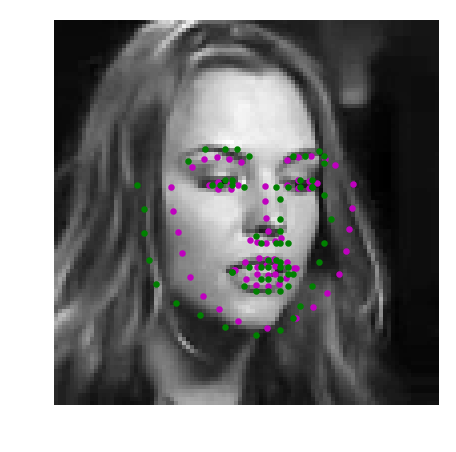

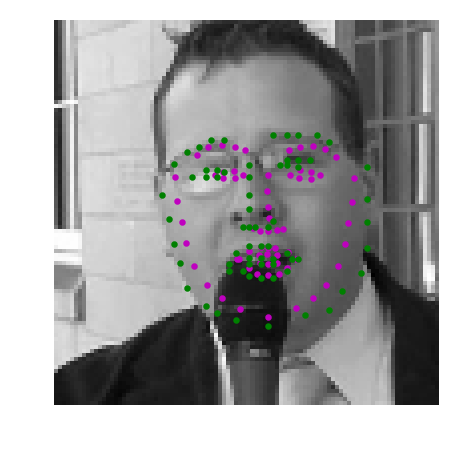

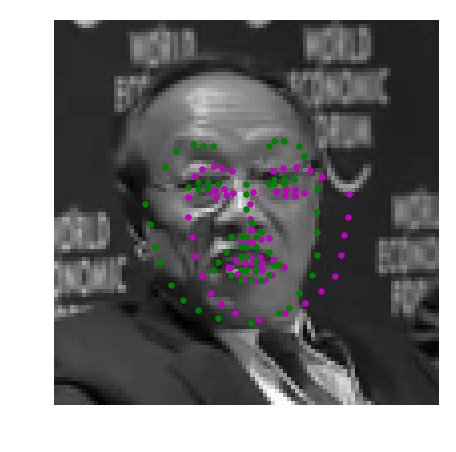

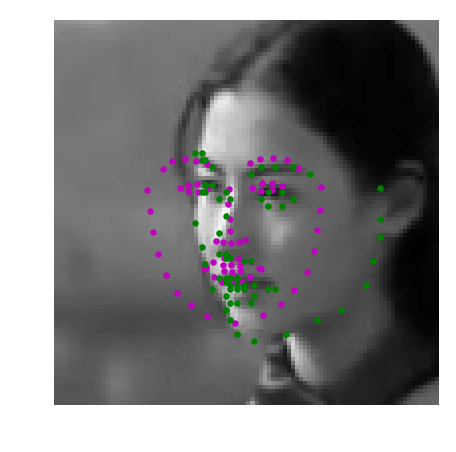

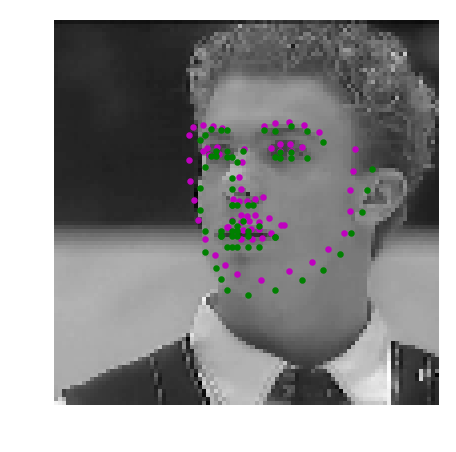

In [17]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)

Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 

- Here, I used the Adam optimizer as it seems to give better results than SGD. 
- For the loss function i chose Smooth L1 loss as it appears to do better than just L1 loss or MSE Loss.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:

I begin with a very large architecture but it was taking too long. So, I removed multiple layers and simplified it. But due to excessive simplicity the model was quite inaccurate. After many changes i finally converged to a model similar to the LeNet architecture. Also, I used a dropout layer to avoid overfitting.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:

I tested with 1 epoch and then shifted to 4 epochs(this is usually what i prefer) therefore, I didn't have to wait too long to observe the results. In order to get more accurate values I slightly increase the number of epochs. I tried with 12 epochs but it didn't seem to have much difference so increased the number to 25. For the Batchsize I made it 30 but there was not much improvement so I changed it back to 10.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.06133175 -0.11009483 -0.0236207  -0.06777869 -0.13428679]
 [ 0.04497096 -0.01937424 -0.2164344  -0.16274615 -0.24837461]
 [ 0.20521685  0.09317613 -0.15322551 -0.04727775  0.05948587]
 [-0.03773145  0.14479385  0.19172932  0.04858196 -0.0083241 ]
 [ 0.12796552  0.15586612 -0.02119713  0.03630716  0.03540428]]
(5, 5)


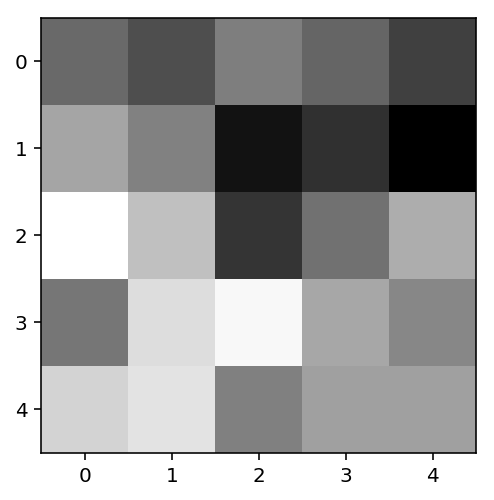

In [33]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 25

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

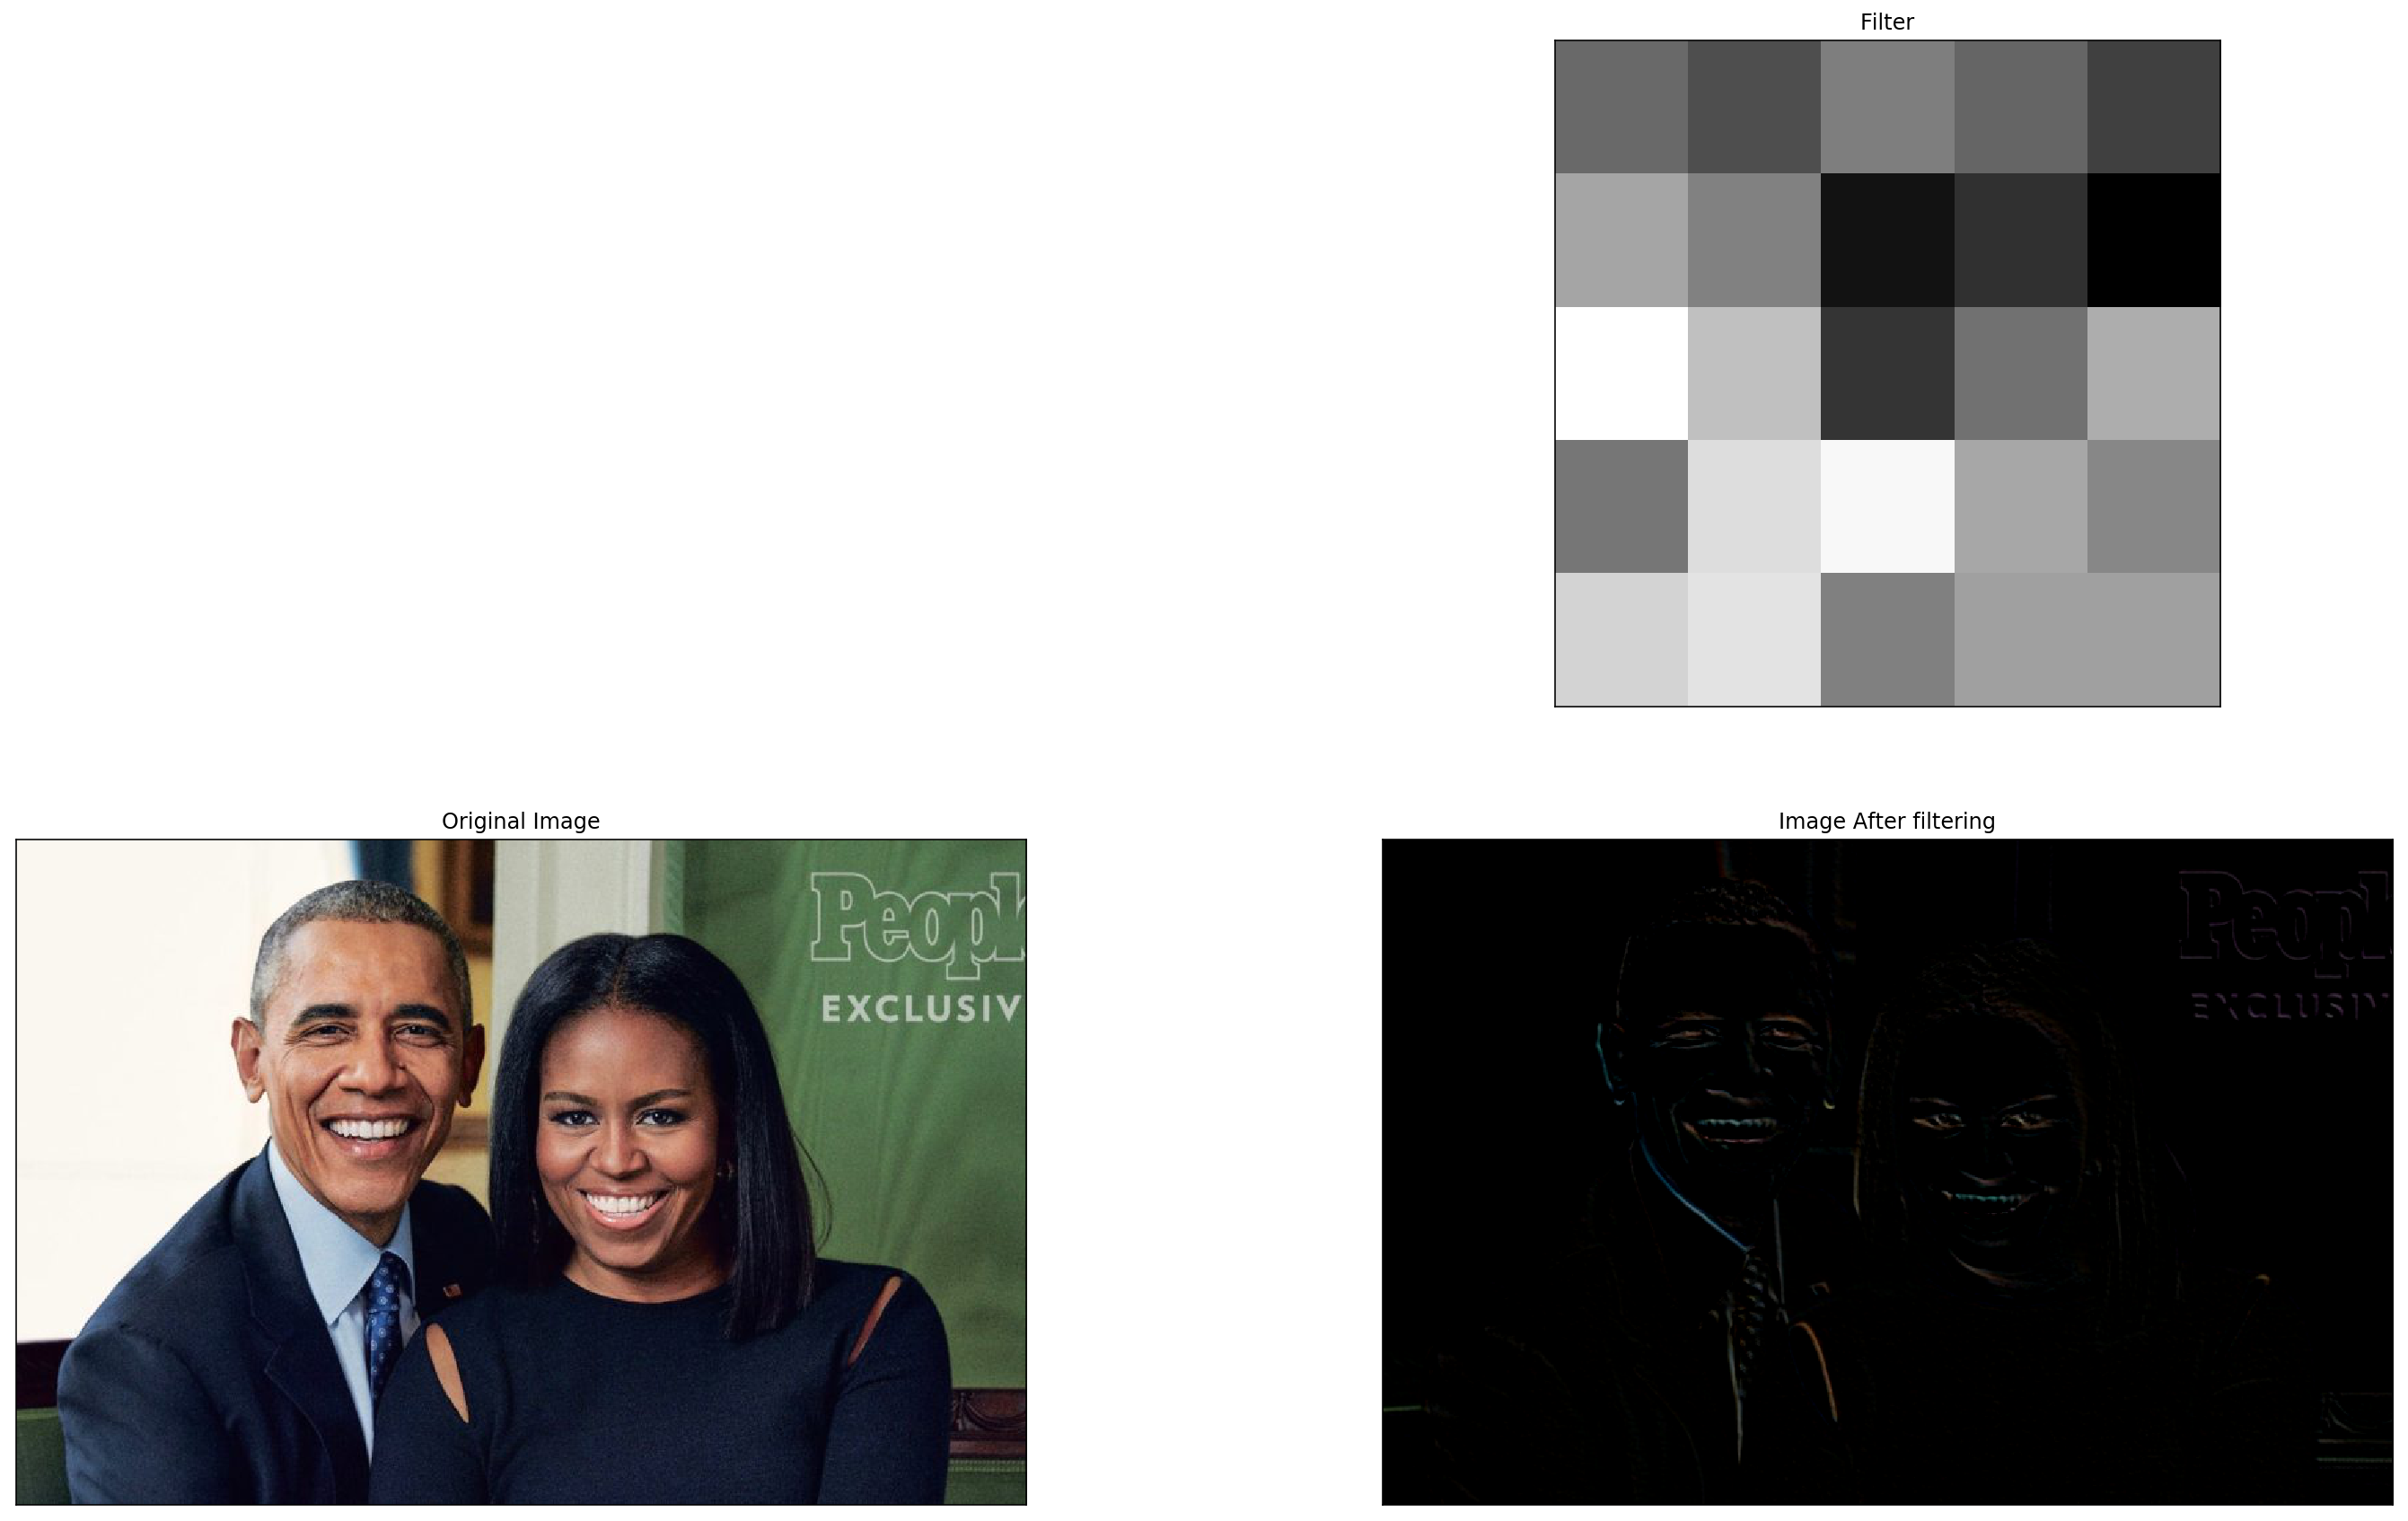

In [34]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

import cv2
my_image = cv2.imread('images/obamas.jpg')

# Converting to rgb
my_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)

# Filter
filtering = cv2.filter2D(my_image, -1, w[filter_index][0])

fig = plt.figure(figsize=(25,15))
ax = fig.add_subplot(223, xticks = [], yticks = [])
ax.imshow(my_image)
ax.set_title("Original Image")

ax = fig.add_subplot(222, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')
ax.set_title("Filter")

ax = fig.add_subplot(224, xticks = [], yticks = [])
ax.imshow(filtering)
ax.set_title("Image After filtering")

plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**:

On seeing the filtered image, the filter applied to it seems to be an edge-detection filter as it mostly identifies the outline of the object.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!